# INDENG 222 - Spring 2024 - HW2 sample solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from scipy.stats import t
from scipy.stats import norm
import math
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta



%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [18, 10]


np.random.seed(222)

<ipython-input-1-fbb3936686d1>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 1 Brownian motion and Black Scholes model

## 1.1 Brownian Motion

### 1.1.1

In [2]:
def brownian_motion(T=1, N=10000, n_paths=1):
    time_steps = np.linspace(0, T, N+1) # N+1 equally spaced points on [0,1], t_i = i/N
    # we know that every increment is N(0, t_i - t_{i-1}), so we generate white noise and
    # rescale it properly, then we cumsum on the first dimensione to get a path
    jump = T/N
    increments = np.sqrt(jump)*np.random.normal(size=(N, n_paths))
    W = np.cumsum(increments, axis=0)
    # We stack W with n_paths 0 at the beginning since we know W_0 = 0
    W = np.vstack((np.zeros((1, n_paths)), W))
    return W

In [95]:
# By using the rescaled random walk, build a program which give one path of a Brownian motion on [0,1]
# with a time subdivision t_i = i/ N , 0 ≤ i ≤ N and give an example of the value taken by W1;
N = 10000
T = 1
BM = brownian_motion(T, N).reshape(-1,)
print(f'W_1 = {str(BM[-1])}')

W_1 = -0.5095377681188487


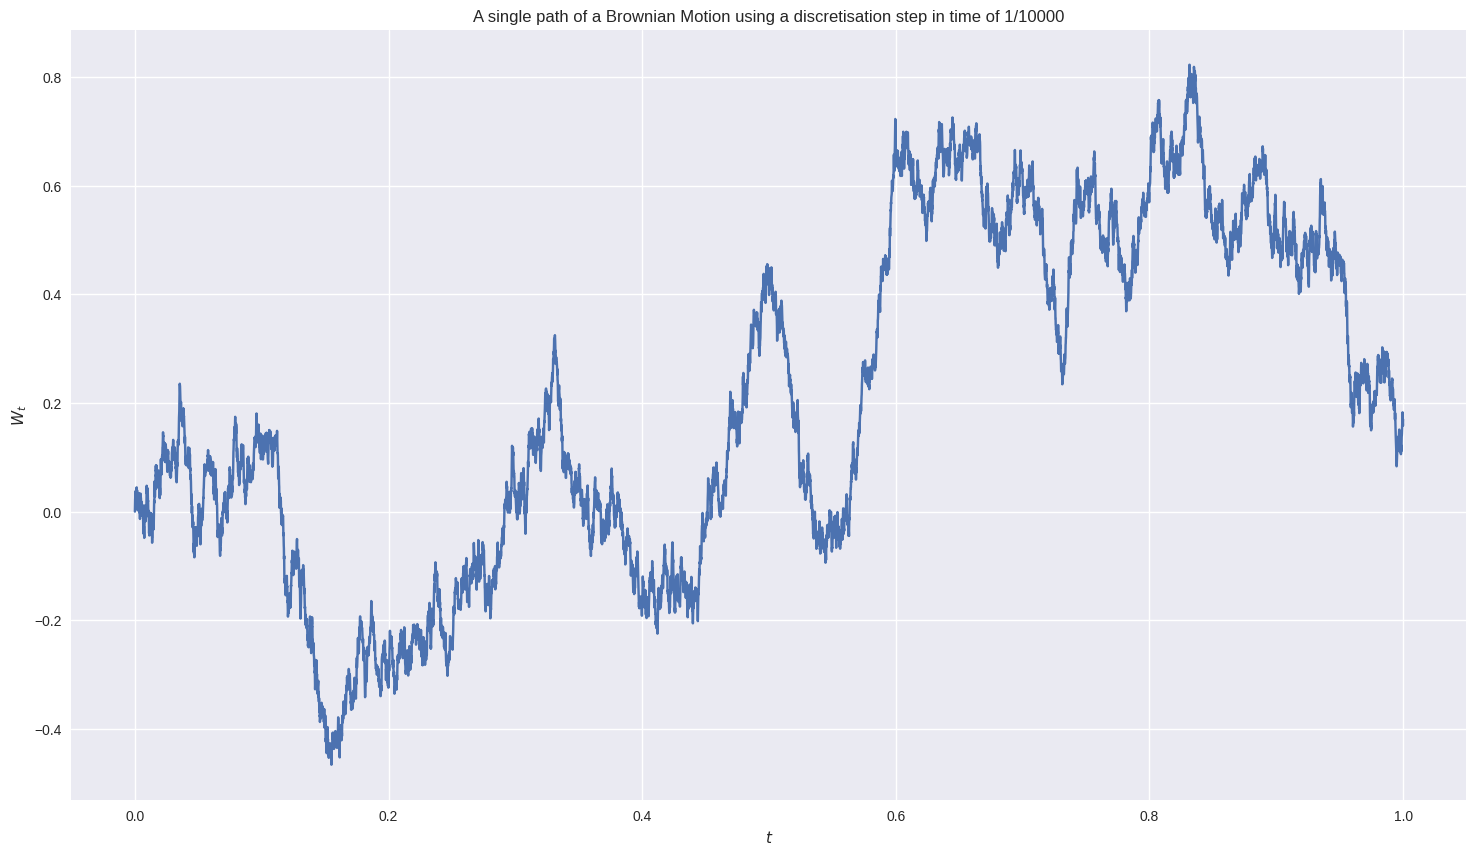

In [4]:
# Plotting of a single path of the brownian motion
time_steps = np.linspace(0, T, N+1)
plt.plot(time_steps, BM)
plt.xlabel('$t$')
plt.ylabel('$W_t$')
plt.title(f'A single path of a Brownian Motion using a discretisation step in time of {T}/{N}')
plt.show()

### 1.1.2

In [5]:
M = 1000
BM_paths = brownian_motion(T, N, M)
mean = np.mean(BM_paths,axis=1)
variance = np.std(BM_paths,axis=1)**2

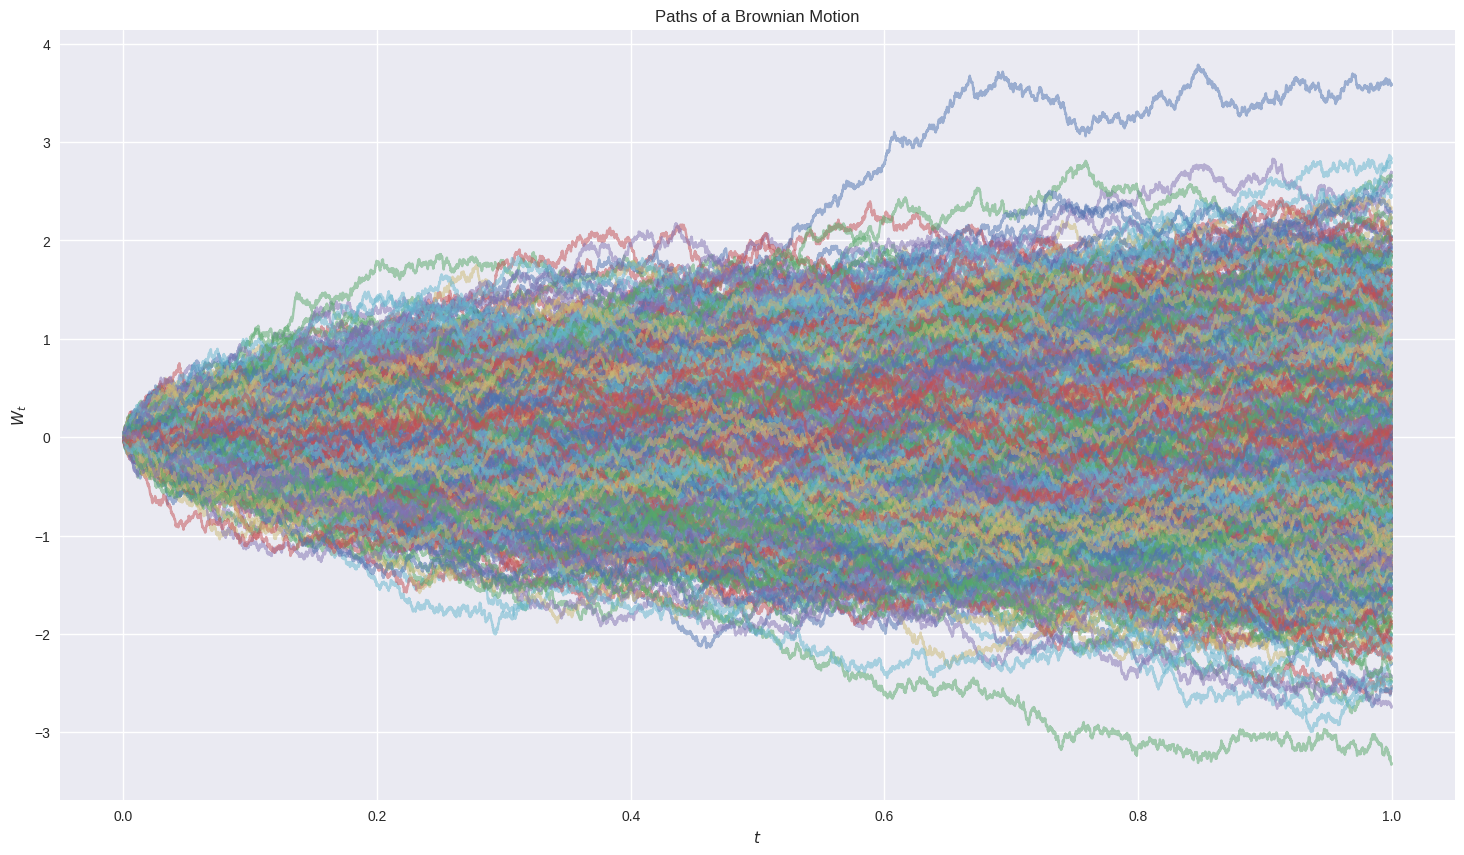

In [6]:
# Plotting of multiple paths of the brownian motion (a bit messy)
plt.plot(time_steps, BM_paths, alpha=0.5)
plt.xlabel('$t$')
plt.ylabel('$W_t$')
plt.title('Paths of a Brownian Motion')
plt.show()

### Discussion about numerical proof that E[W_t]= 0 and Var(W_t) = t

We can use statistical testing to try to reject the null hypothesis that the mean of the BM_paths is 0 and its variance is t, for every t in the time_steps. To do so, we have imported the ttest functions from scipy. If the corresponding p_values of the test are high enough, we cannot reject the null hypothesis and therefore we cannot claim the mean and variance to be different from the theoretical values. The higher the p_value, the stronger the case for the theoretical value is.

First, we are going to show that, graphically, mean is always very close to 0 and variance to the time_step for every time step, then we are going to give statistical sounding to our findings.

The idea of t testing came from a discussion with the group formed by Mehdi Badri, François Porcher and Wael Rahioui

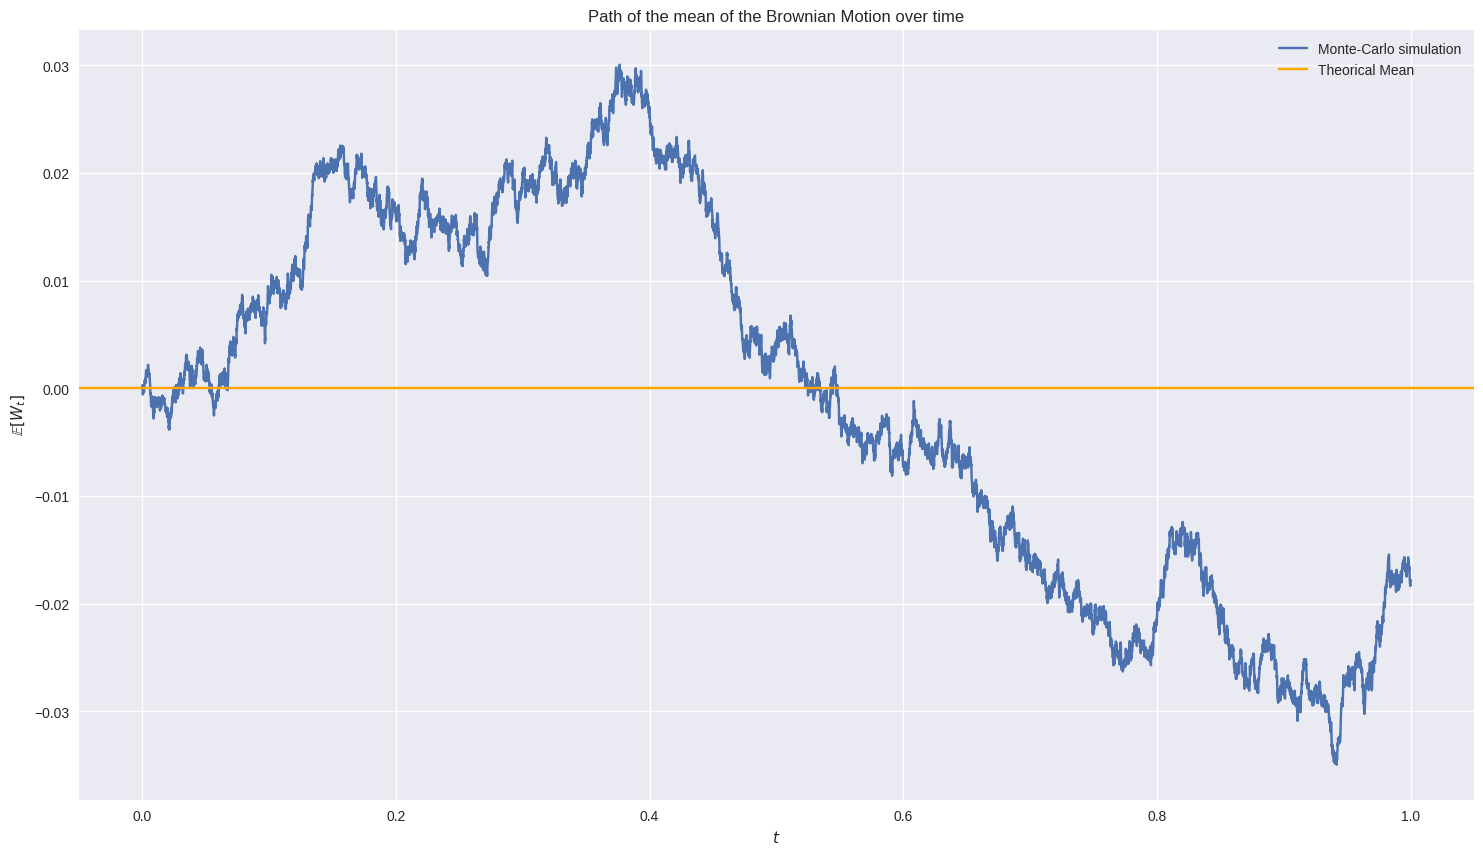

In [7]:
plt.plot(time_steps, mean, label = 'Monte-Carlo simulation')
plt.axhline(y=0, color='orange', label = 'Theorical Mean')
plt.xlabel('$t$')
plt.legend()
plt.ylabel('$\mathbb{E}[W_t]$')
plt.title('Path of the mean of the Brownian Motion over time')
plt.show()


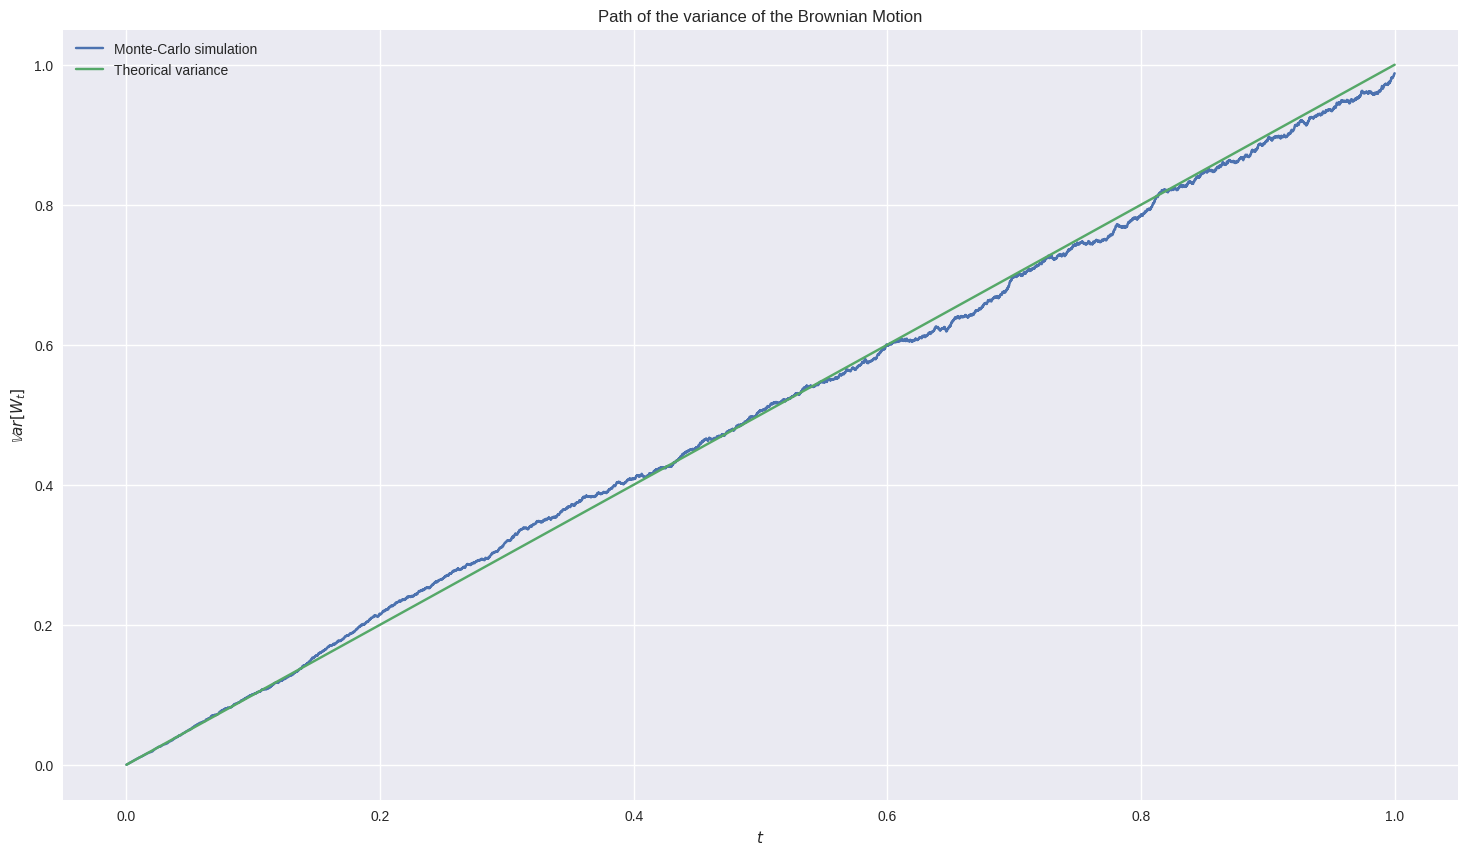

In [8]:
plt.plot(time_steps,variance,label = 'Monte-Carlo simulation')
plt.plot(time_steps,time_steps,label = 'Theorical variance ')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\mathbb{V}ar[W_t]$')
plt.title('Path of the variance of the Brownian Motion')
plt.show()

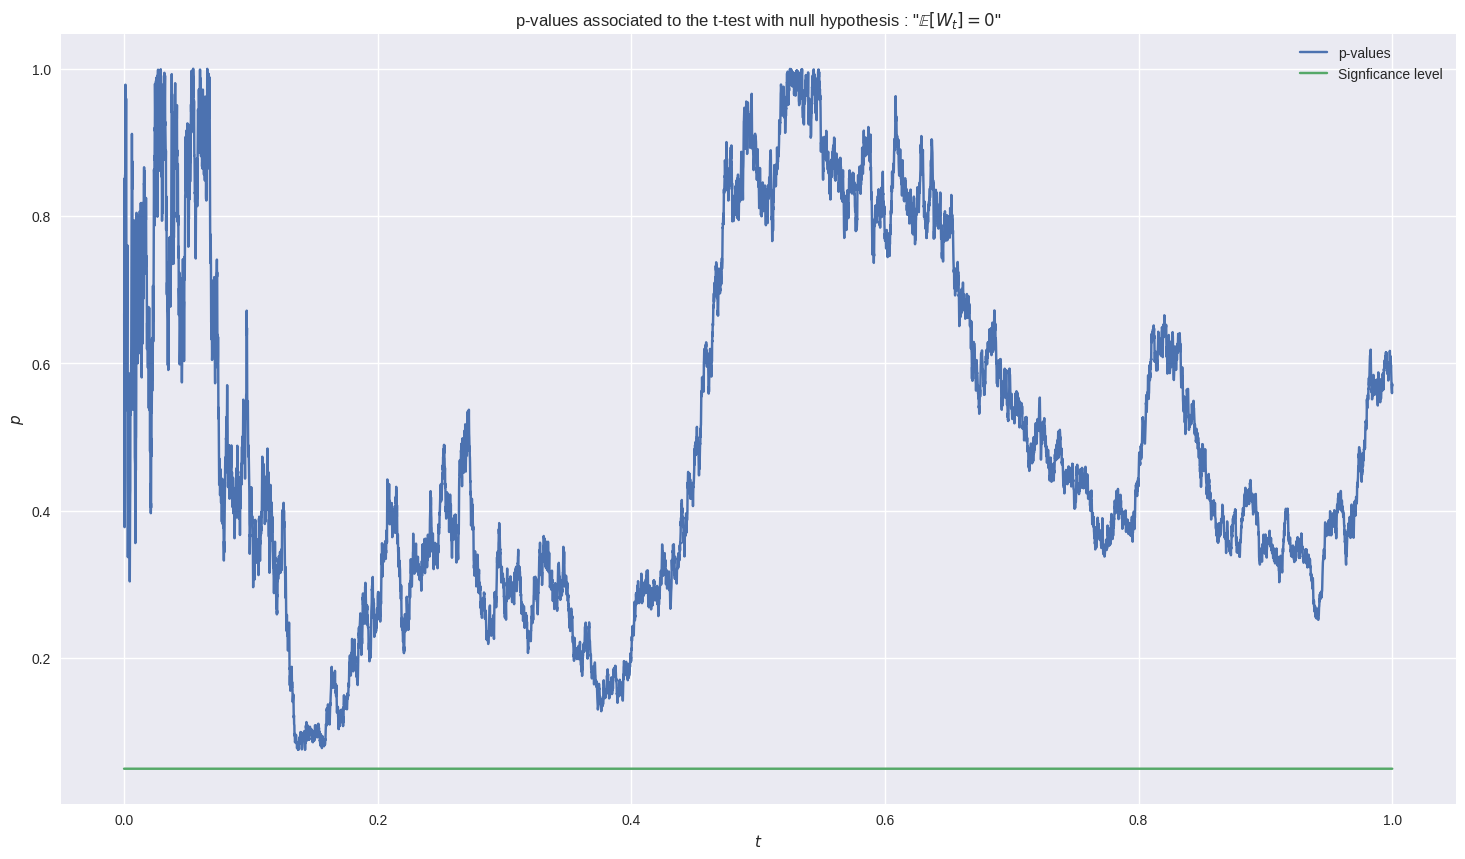

In [9]:
lst_pval = []
significance_level = 0.05
for time in range(N+1):
    sample = BM_paths[time,:]
    #sample_mean = np.mean(sample)
    #sample_std = np.std(sample)
    t_statistic, p_value = ttest_1samp(sample, popmean=0)
    lst_pval.append(p_value)

plt.plot(time_steps,lst_pval, label = 'p-values')
plt.plot(time_steps,[significance_level for x in lst_pval],label = 'Signficance level')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$p$')
plt.title('p-values associated to the t-test with null hypothesis : "$\mathbb{E}[W_t]=0$" ')
plt.show()

We see that p-values are all well above the level of 5% so, with a significance level of 95% we fail to reject the null hypothesis that for all $t$ the mean is equal to 0. Therefore we cannot contraddict the fact that : $$\forall t\geq0 , \mathbb{E}[W_t]=0 $$ or, losing the statistical terminology, we can claim with a great amount of confidence that $$\forall t\geq0 , \mathbb{E}[W_t]=0 $$.

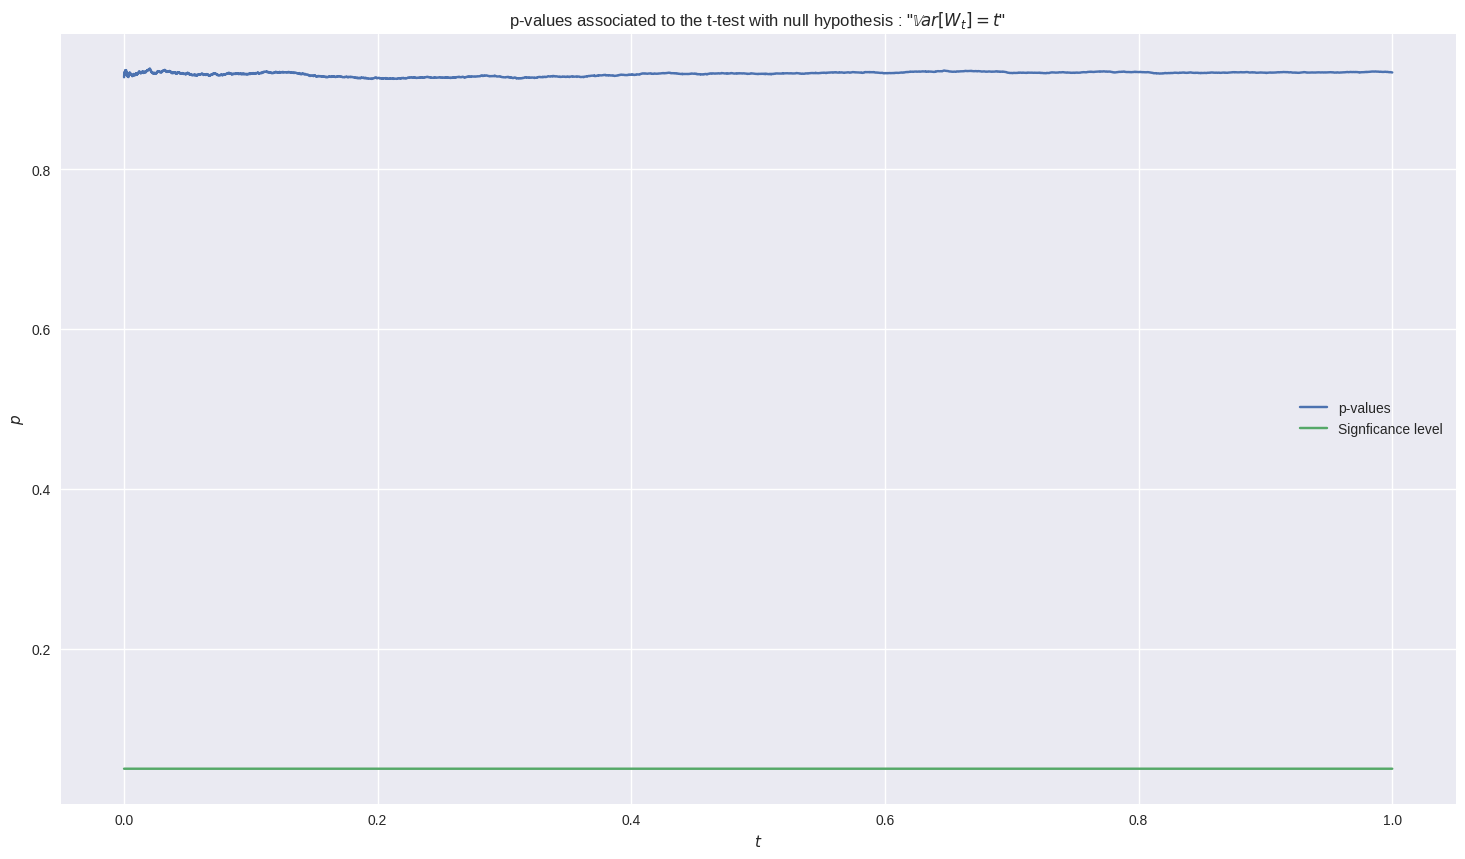

In [10]:
lst_pval = []
significance_level = 0.05
for time in range(1, N+1):
    sample = BM_paths[time,:]
    sample_var =np.std(sample)**2
    expected_var = time
    degrees_of_freedom = len(sample) - 1
    t_statistic = degrees_of_freedom * sample_var / expected_var
    p_value = 2 * t.cdf(-np.abs(t_statistic), degrees_of_freedom)
    lst_pval.append(p_value)

plt.plot(time_steps[1:],lst_pval, label = 'p-values')
plt.plot(time_steps[1:],[significance_level for x in lst_pval],label = 'Signficance level')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$p$')
plt.title('p-values associated to the t-test with null hypothesis : "$\mathbb{V}ar[W_t]=t$" ')
plt.show()

In the same way, we see that all p-values are above the significance level also for the variance case, so that we fail to reject the null hypothesis for all $t$, We can then say that : $$\forall t>0 , \mathbb{V}ar[W_t]=t.$$


### 1.1.3

In [11]:
times = np.linspace(0.1, 1, 10)
mean_quadratic_var = np.zeros(len(times))
var_quadratic_var = np.zeros(len(times))
for i in range(len(times)):
    mean_quadratic_var[i] = np.mean(np.sum(np.diff(BM_paths[0:int((times[i]*N))+1], axis=0)**2, axis=0))
    var_quadratic_var[i] = np.std(np.sum(np.diff(BM_paths[0:int((times[i]*N))+1], axis=0)**2, axis=0))

In [12]:
table = pd.DataFrame(columns = ['Theorical','Simulated', 'Residuals', 'Variance'],
                     data = {'Theorical':times,'Simulated':mean_quadratic_var,
                             'Residuals': times - mean_quadratic_var, 'Variance': var_quadratic_var})
table

,Theorical,Simulated,Residuals,Variance
0,0.1,0.100009,-0.000009,0.004473
1,0.2,0.199667,0.000333,0.006409
2,0.3,0.299579,0.000421,0.007776
3,0.4,0.399682,0.000318,0.008825
4,0.5,0.499763,0.000237,0.009969
5,0.6,0.599775,0.000225,0.011034
6,0.7,0.699842,0.000158,0.011907
7,0.8,0.799926,0.000074,0.012829
8,0.9,0.899991,0.000009,0.013475
9,1.0,0.999970,0.000030,0.014171


We can see as the simulated mean is very close to the value of t, while all variances are close to 0.

## 1.2 Stochastic Integral

### 1.2.1

In [189]:
W = brownian_motion(T=1, N=10000, n_paths=1000)
W_T = W.T

In [190]:
I_upper = np.mean(np.sum(W_T[:, 1:]*np.diff(W_T, axis = 1), axis = 1))
I_upper = np.mean(np.sum(W_T[:, 1:]*np.diff(W_T, axis = 1), axis = 1))

In [191]:
0.5*np.mean(W_T[:, -1]**2)+0.5

0.9917480255854471

### 1.2.2

In [192]:
I_lower = np.mean(np.sum(W_T[:, :-1]*np.diff(W_T, axis = 1), axis = 1))
I_lower

-0.008268543383742366

In [193]:
0.5*np.mean(W_T[:, -1]**2)-0.5

-0.008251974414552943

### 1.2.3

choose I lower

### 1.2.4

https://math.stackexchange.com/questions/2184422/expectation-and-variance-of-int-0t-wsdws

In [196]:
0.5*np.mean(W_T[:, -1]**2)-0.5

-0.008251974414552943

In [197]:
0.25*np.mean(W_T[:, -1]**4) - 0.5*np.mean(W_T[:, -1]**2) + 0.25

0.48042493192454017

## 1.3 Black-Scholes model

### 1.3.1 Solution to SDE

#### 1.3.1.1

#### 1.3.1.2

### 1.3.2 Black-Scholes price of European call and put option

#### 1.3.2.1

In [13]:
# uses Black-Scholes-Merton to find prices of a call option
def CallBS(r, sigma, S_0, T, K):
    # calculate d+
    d_1 = (np.log(S_0/K) + T*(r + (sigma**2)/2))/(sigma*np.sqrt(T))
    # calculate d-
    d_2 = d_1 - sigma*np.sqrt(T)
    #return price of call option
    return S_0*norm.cdf(d_1) - K*np.exp(-r*T)*norm.cdf(d_2)

In [14]:
# uses Black-Scholes-Merton to find prices of a put option
def PutBS(r, sigma, S_0, T, K):
    d_1 = (np.log(S_0/K) + T*(r + (sigma**2)/2))/(sigma*np.sqrt(T))
    d_2 = d_1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d_2) - S_0*norm.cdf(-d_1)


#### 1.3.2.2

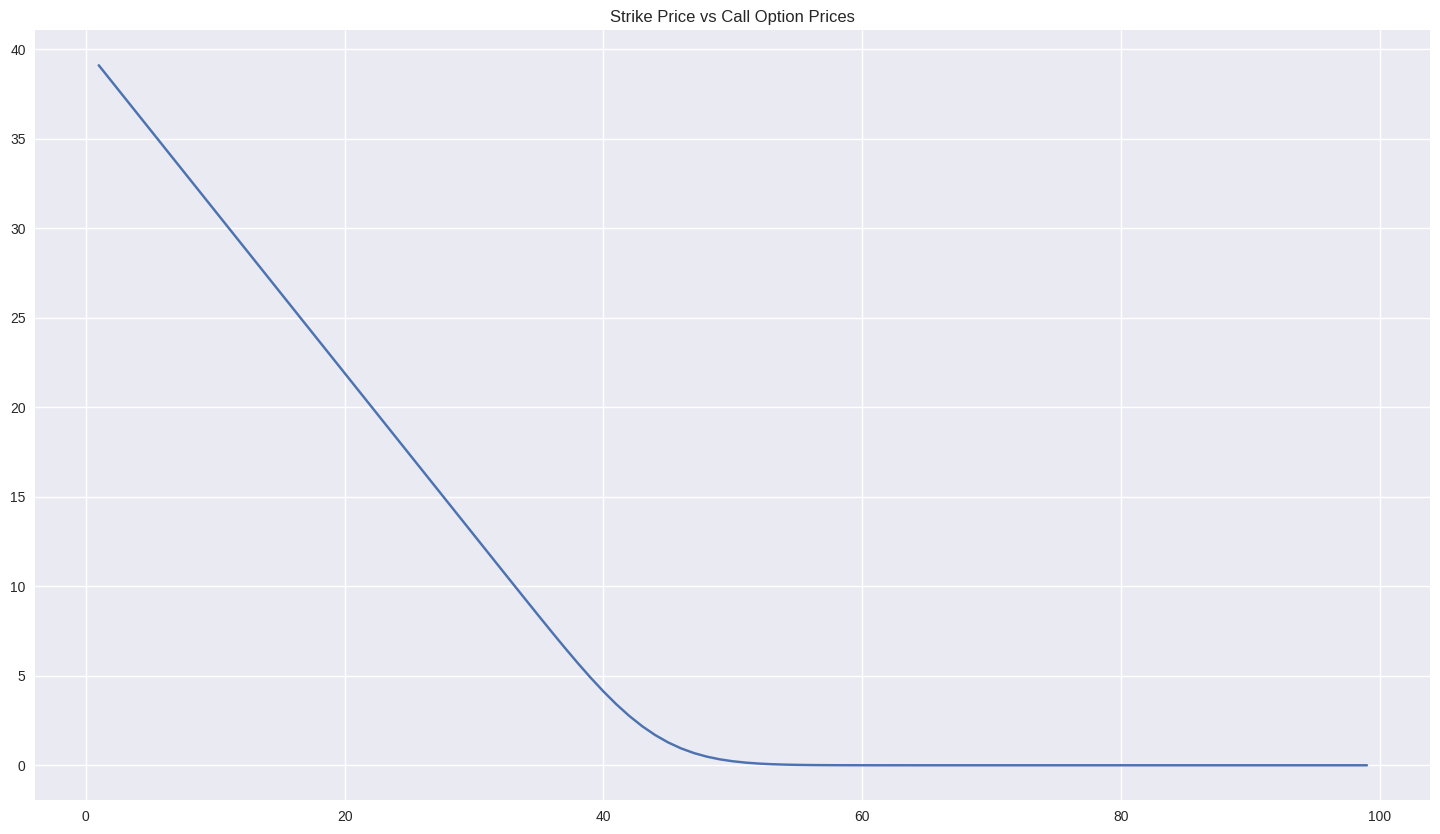

In [15]:
#Generate range of strike prices from 1 to 100
strike_prices = [i for i in range(1,100)]
#define variables
S_0, sigma, r, T = 40, 0.1, 0.1, 1
#Generate call option prices
prices = [CallBS(0.1, sigma, S_0, T, K) for K in strike_prices]

# Plot strikes prices vs call option prices
plt.plot(strike_prices, prices)
plt.title('Strike Price vs Call Option Prices')
plt.show()

We observe that the price at time 0 of a call option is convex with respect to the strike price.

#### 1.3.2.3

In [16]:
# show that put-call parity holds
CallBS(0.1, 0.1, 50, 1, 55) - PutBS(0.1, 0.1, 50, 1, 55) == 50 - 55*np.exp(-0.1*(1-0))

True

## 1.4 Approximation formula

### 1.4.1

In [23]:
CallBS(0.1, 0.1, 40, 1, 40*np.exp(0.1*1))

1.5951044670697954

In [24]:
0.4*40*0.1*np.sqrt(1)

1.6

### 1.4.2

In [37]:
# compute delta of call option
def delta(r, sigma, S_0, T, K):
    d_1 = (np.log(S_0/K) + T*(r + (sigma**2)/2))/(sigma*np.sqrt(T))
    return norm.cdf(d_1)

In [45]:
delta(0.1, 0.1, 40, 1, 40*np.exp(0.1*1))

0.5199388058383723

In [48]:
0.5 + 0.2*40*np.sqrt(1)

8.5

### 1.4.3

In [31]:
# compute vega of call option
def vega(r, sigma, S_0, T, K):
    d_1 = (np.log(S_0/K) + T*(r + (sigma**2)/2))/(sigma*np.sqrt(T))
    return S_0 * (norm.pdf(d_1)) * np.sqrt(T)

In [32]:
vega(0.1, 0.1, 40, 1, 40*np.exp(0.1*1))

15.937756563790561

In [33]:
0.4*40*np.sqrt(1)

16.0

# 2 Black-Scholes v.s. Bachelier

## 2.1

In [49]:
def CallBach(r, sigma, S_0, T, K):
  d_plus = (S_0*np.exp(r*T) - K)/(sigma*np.sqrt(T))
  return np.exp(-r*T)*sigma*np.sqrt(T)*(d_plus*norm.cdf(d_plus) + norm.pdf(d_plus))

In [50]:
CallBach(0, 0.2, 40, 1, 35)

5.0

## 2.2

In [ ]:
0 <= CallBach(0, 0.2*40, 40, 1, 40) - CallBS(0, 0.2, 40, 1, 40) <= 40/(24*np.sqrt(2*np.pi)) * (np.abs(0.2) ** 3) * (1 ** (3/2))

True

# 3 Pricing Asian option in the Black-Scholes model

## 3.1

In [67]:
def CallAsian(r, sigma, S_0, T, K):
  N = 1000
  jump = T/N
  simulations = 10000
  S = np.zeros((N+1, simulations))
  S[0] = S_0
  for i in range(1, N + 1):
    S[i] = S[i-1] * np.exp((r - 0.5 * (sigma ** 2)) * jump + sigma * np.sqrt(jump) * np.random.standard_normal(simulations))
  arithmetical_mean = np.maximum(np.mean(S[-N:], axis = 0) - K, 0)
  arithmetical_mean_price = np.exp(-r*T)*np.sum(arithmetical_mean)/simulations

  geometric_mean = np.maximum((np.prod(S[-N:], axis = 0) ** (1/(N+1))) - K, 0)
  geometric_mean_price = np.exp(-r*T)*np.sum(geometric_mean)/simulations

  return arithmetical_mean_price, geometric_mean_price

In [72]:
CallAsian(0.05, 0.2, 100, 1, 105)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(3.49692117579439, inf)

In [71]:
CallBS(0.1, 0.1, 40, 1, 50)

0.22348654299153914

## 3.2

## 3.3

# 4 Pricing zero-coupon bond in the Vasicek model

## 4.1

In [ ]:
def vasicek_model_interest_rate_path(a = 1, b = 0.06, sigma = 0.3, T = 1, N = 10000, n_paths = 1):
    jump = T / N
    time_steps = np.linspace(0, T, N+1)
    increments = np.sqrt(jump) * np.random.normal(size=(n_paths, N))
    paths = np.zeros((n_paths, N+1))
    paths[:, 0] = 0.05
    for j in range(N):
        paths[:, j+1] = paths[:, j] + a * (b - paths[:, j]) * jump + sigma * increments[:, j]
    return paths

## 4.2

In [ ]:
paths = vasicek_model_interest_rate_path(a = 1, b = 0.06, sigma = 0.3, T = 0.5, N = 10000, n_paths = 1000)

In [ ]:
jump = 1 / 10000

In [ ]:
vasicek_model_price = np.mean(np.exp(-1*np.array([np.sum(p*jump) for p in paths])))
vasicek_model_price

0.9553834319446715

## 4.3

In [ ]:
b = 0.06
a = 1
r_0 = 0.05
T = 0.5
sigma = 0.3

In [ ]:
np.exp(-b*T + (b-r_0)*(1-np.exp(-a*T))/a - (sigma ** 2)/(4*(a**3))* ((1-np.exp(-a*T)))**2 + (sigma**2)/(2*(a**2)) * (T - (1-np.exp(-a*T))/a))

0.9755490535383189

### Q2.1: Monte Carlo pricer

In [ ]:
# values we are going to use in the next part of the notebbok
S0_std = 100
K_std = 100
r_std = 0.1
sigma_std = 0.1
T_std = 1

In [ ]:
# St as log_normal using the previously computed brownian paths BM
St = S0_std*np.exp(sigma_std*BM_paths +(r_std-0.5*sigma_std**2)*(time_steps.reshape(-1, 1)))

In [ ]:
St.shape

(10001, 1000)

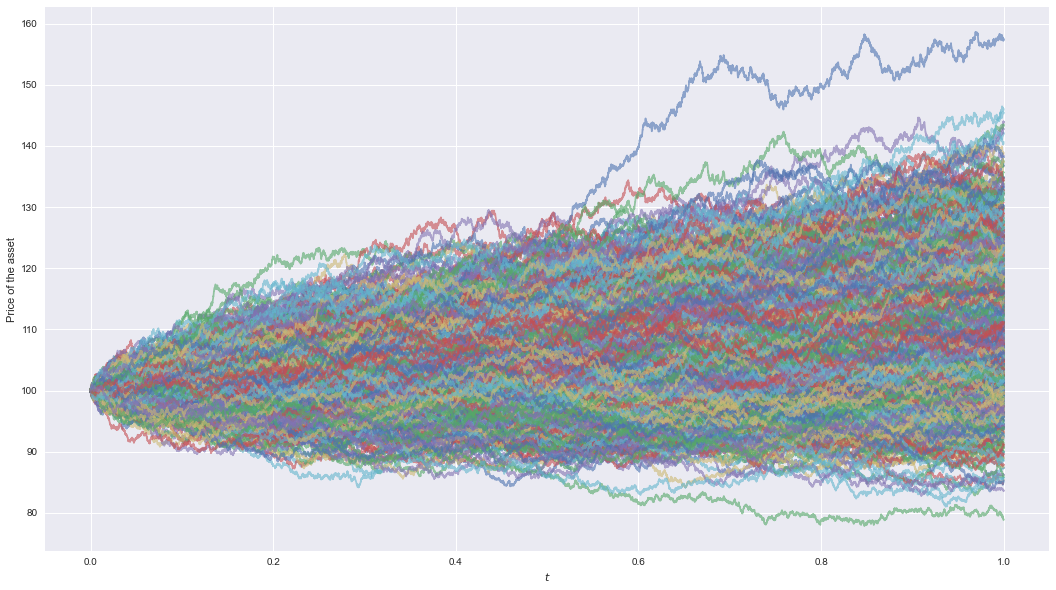

In [ ]:
plt.plot(time_steps, St,alpha =0.6)
plt.xlabel('$t$')
plt.ylabel('Price of the asset')
plt.show()

In [ ]:
terminal_value = np.maximum(St[-1,:] - K_std, 0)

In [ ]:
option_price = np.exp(-r_std*T)*np.mean(terminal_value)

In [ ]:
option_price

10.102518093437581

## Black-Scholes price of European options

### Q2.2: definition of the CallBS and PutBS function

In [ ]:
def callBS(T=1, S0=100, K=100, r=0.1, sigma=0.1):
    d_plus = (math.log(S0/K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d_minus = d_plus - sigma * math.sqrt(T)
    N1 = norm.cdf(d_plus)
    N2 = norm.cdf(d_minus)
    call_price = S0 * N1 - K * math.exp(-r * T) * N2
    return call_price

def putBS(T=1, S0=100, K=100, r=0.1, sigma=0.1):
    d_plus = (math.log(S0/K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d_minus = d_plus - sigma * math.sqrt(T)
    N1 = norm.cdf(-d_plus)
    N2 = norm.cdf(-d_minus)
    put_price = K * math.exp(-r * T) * N2 - S0 * N1
    return put_price

In [ ]:
callBS()

10.308150925634422

As you can notice the two prices are fairly similar considering that we have a Montecarlo with 1000 scenarios (in the default setting). Montecarlo uses Central Limit Theorem and has a convergence of sqrt(N)!

### Q2.3: convexity of the option price wrt the strike

In [ ]:
S0 = 50
T = 1
sigma = 0.1
r = 0.1

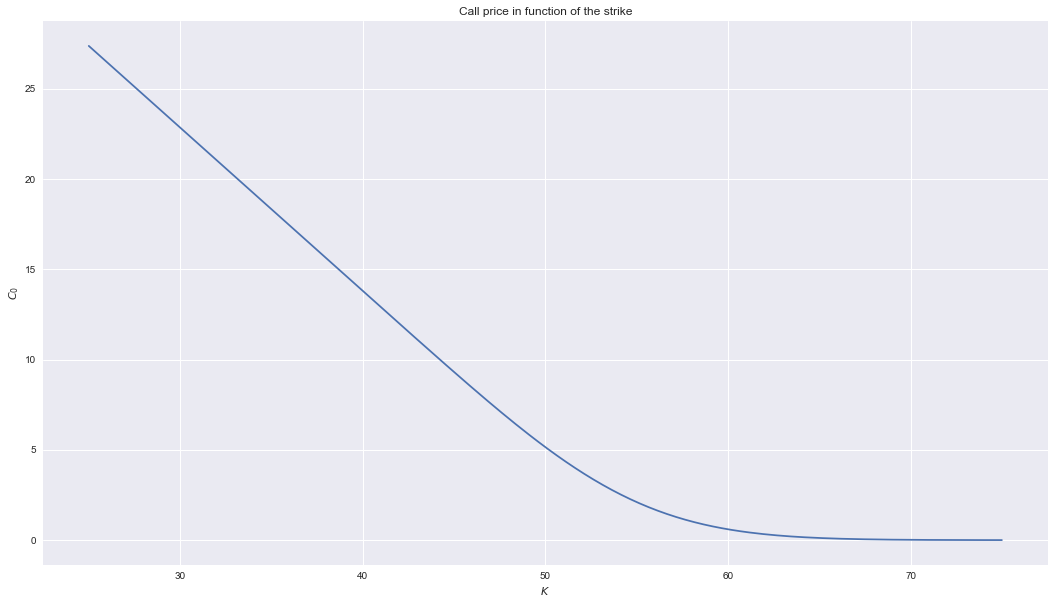

In [ ]:
lst_CBS_k = [callBS(S0=S0, K=k, T=T, sigma=sigma, r=r) for k in np.linspace(S0 - np.round(0.5*S0), S0+ np.round(0.5*S0),200)]
plt.plot(np.linspace(S0 - np.round(0.5*S0), S0+ np.round(0.5*S0),200),lst_CBS_k)
plt.xlabel('$K$')
plt.ylabel('$C_0$')
plt.title('Call price in function of the strike')
plt.show()

### Q2.4: check for Put-Call parity

In [ ]:
def putcall_check(tol=1e-5, T=1, S0=50, K=55, r=0.1, sigma=0.1):
    call_price = callBS(T=T, S0=S0, K=K, r=r, sigma=sigma)
    put_price = putBS(T=T, S0=S0, K=K, r=r, sigma=sigma)
    return np.abs(call_price - put_price - S0 + K*np.exp(-r*T)) <= tol

In [ ]:
putcall_check()

True

### Q2.5: Delta

In [ ]:
def delta_callBS(T=1, S0=100, K=100, r=0, sigma=0.1):
    d_plus = (math.log(S0/K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    N1 = norm.cdf(d_plus)
    return N1

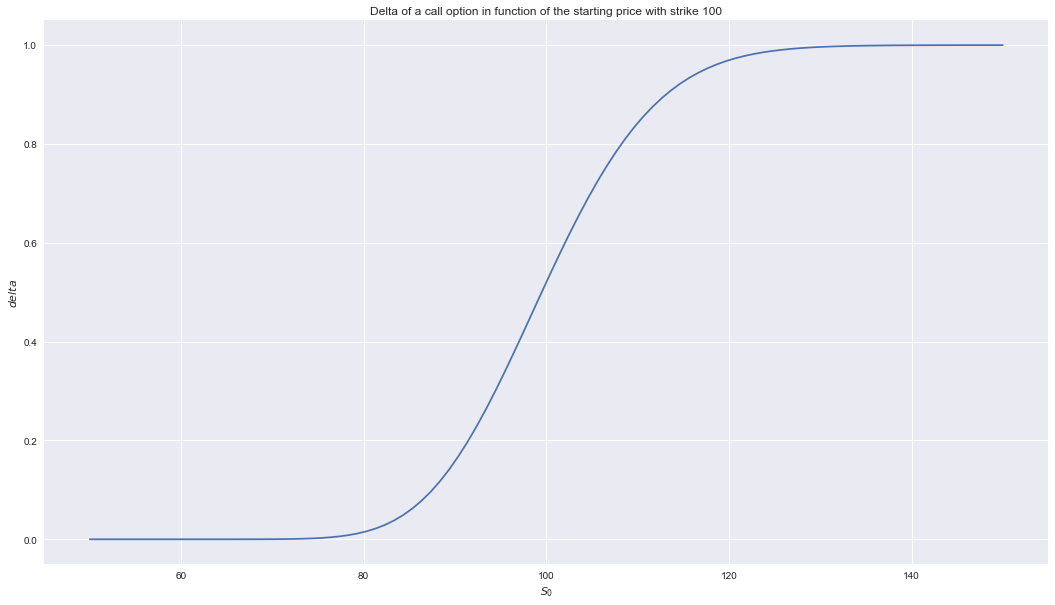

In [ ]:
K = 100
lst_CBS_delta = [delta_callBS(S0 = s) for s in np.linspace(K - int(0.5*K), K + int(0.5*K),100)]
plt.plot(np.linspace(K - int(0.5*K), K + int(0.5*K),100),lst_CBS_delta)
plt.xlabel('$S_0$')
plt.ylabel('$delta$')
plt.title(f'Delta of a call option in function of the starting price with strike {K}')
plt.show()

### Q2.6: Increasing of the option price wrt the volatility

Financial intuition tells us that the more volatility the bigger the probability of having big movements in the underlying asset, but since we are shield from big losses with the option (we simply do not exercise the option), we only care for the "good" (wrt to our position) big movements in the underlying and therefore the bigger the volatility the higher the price of the option. This explain also why the derivative with respect of the volatility (vega) of the option is always positive.

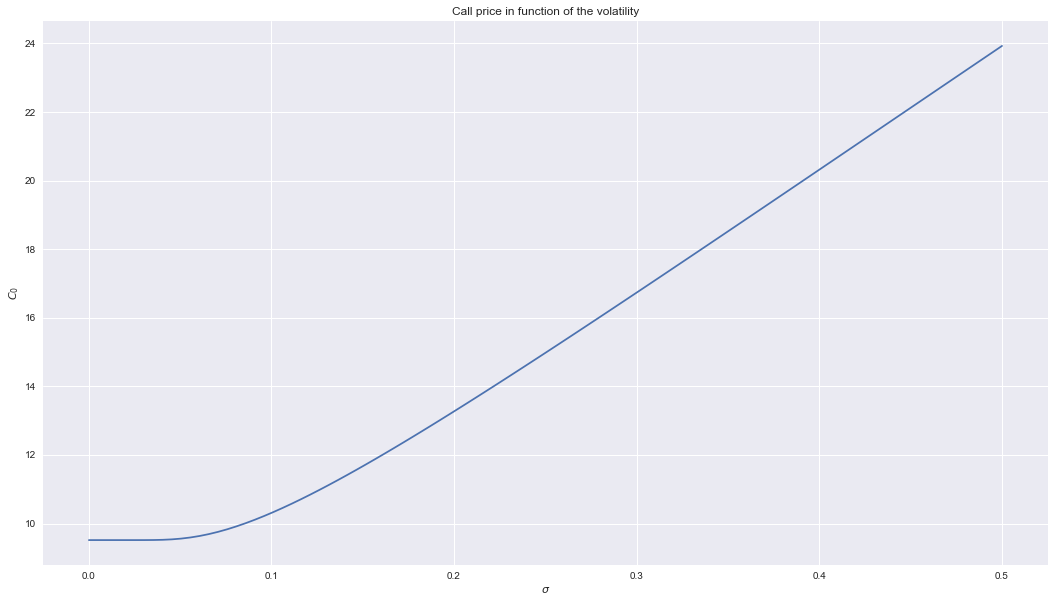

In [ ]:
lst_CBS_sig = [callBS(sigma =s) for s in np.linspace(0.0001,0.5,100)]
plt.plot(np.linspace(0.0001,0.5,100),lst_CBS_sig)
plt.xlabel('$\sigma$')
plt.ylabel('$C_0$')
plt.title('Call price in function of the volatility')
plt.show()

In [ ]:
def vega_callBS(T=1, S0=100, K=100, r=0, sigma=0.1):
    d_plus = (math.log(S0/K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    N1 = norm.pdf(d_plus)
    return S0*N1*np.sqrt(T)

In [ ]:
vega_callBS()

39.8443914094764

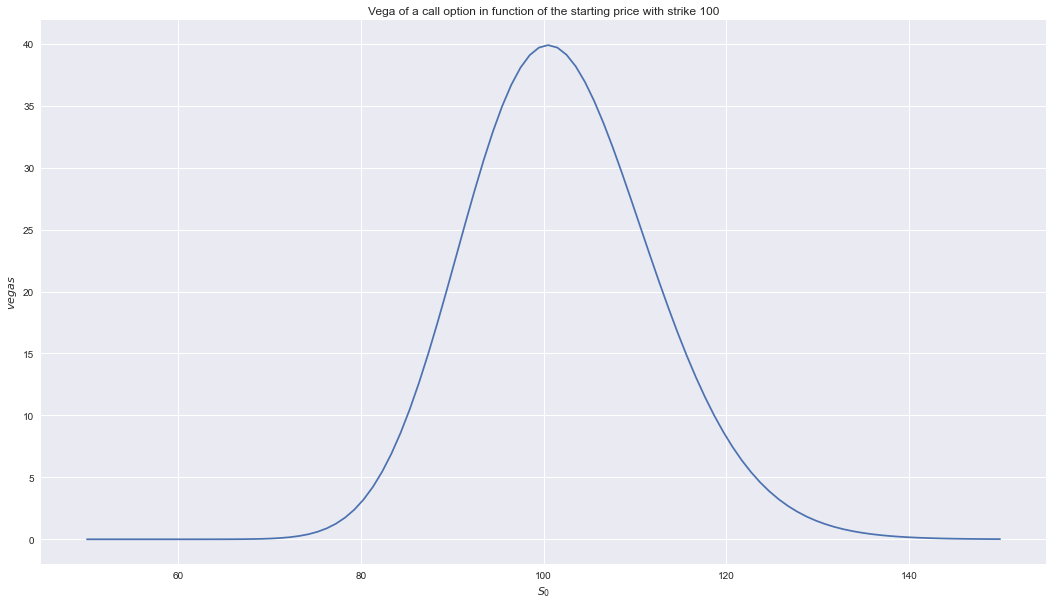

In [ ]:
K = 100
lst_CBS_delta = [vega_callBS(S0 = s) for s in np.linspace(K - int(0.5*K), K + int(0.5*K),100)]
plt.plot(np.linspace(K - int(0.5*K), K + int(0.5*K),100),lst_CBS_delta)
plt.xlabel('$S_0$')
plt.ylabel('$vegas$')
plt.title(f'Vega of a call option in function of the starting price with strike {K}')
plt.show()

In [ ]:
def vega_approx(tol=1e-3, T=1, S0=100, K=100, r=0, sigma=0.1, sigma_tilde=sigma+1e-2):
    true_price = callBS(T=T, S0=S0, K=K, r=r, sigma=sigma_tilde)
    approx = callBS(T=T, S0=S0, K=K, r=r, sigma=sigma) + vega_callBS(T=T, S0=S0, K=K, r=r, sigma=sigma)*(sigma_tilde - sigma)
    return np.abs(true_price - approx) <= tol

In [ ]:
vega_approx()

True

As we can see, vega is higher where the starting price is close to the strike (at the money option), since it is close to the boundary between deciding the reedem the option or not exercising i. For deep out of the money or in the money options this value is close to 0 because no matter the direction, we know already what our decision will be.